# Определение возраста покупателей

Проект для сетевого супермаркета «Хлеб-Соль» 

«Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. 
Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:
- Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
- Контролировать добросовестность кассиров при продаже алкоголя.

Необходимо построить модель, которая по фотографии определит приблизительный возраст человека


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from PIL import Image

import warnings
warnings.filterwarnings("ignore")

In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.applications.resnet import ResNet50

## Исследовательский анализ данных

<b> Загрузим выборку </b></font><br>



In [3]:
labels = pd.read_csv('/datasets/faces/labels.csv')
datagen = ImageDataGenerator(rescale=1./255)
datagen_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345) 

Found 7591 validated image filenames.


Её размер составляет 7591 объект. Каждой фотографии соответствует столбец с возрастом.

In [4]:
labels.info()
labels.describe()

<class 'pandas.core.frame.DataFrame'>

RangeIndex: 7591 entries, 0 to 7590

Data columns (total 2 columns):

 #   Column     Non-Null Count  Dtype 

---  ------     --------------  ----- 

 0   file_name  7591 non-null   object

 1   real_age   7591 non-null   int64 

dtypes: int64(1), object(1)

memory usage: 118.7+ KB


,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


In [6]:
features, target = next(datagen_flow)

<b> Построим график распределения возраста</b></font><br>

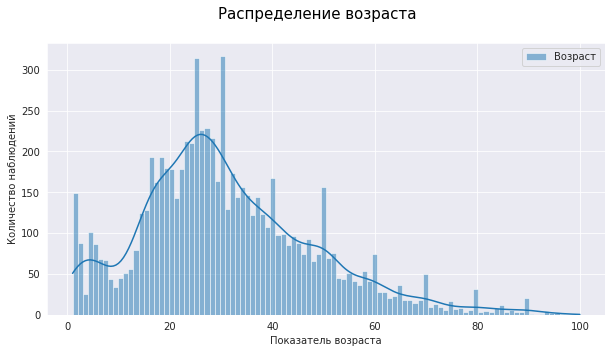

In [7]:
plt.figure(figsize=[10, 5])
plt.suptitle('Распределение возраста', fontsize=15)
sns.set_style('darkgrid')
sns.histplot(labels, color='y', label='Возраст', kde=True, bins=100)
plt.xlabel('Показатель возраста')
plt.ylabel('Количество наблюдений')
plt.legend()
plt.show();

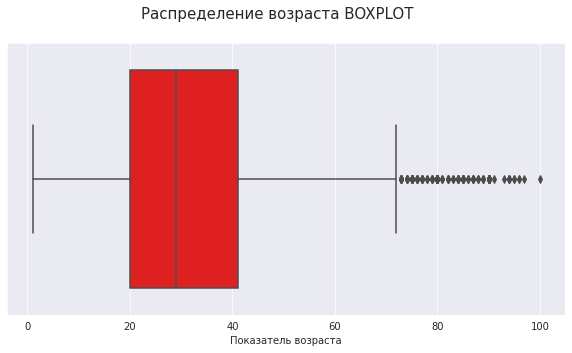

In [6]:
plt.figure(figsize=[10, 5])
plt.suptitle('Распределение возраста BOXPLOT', fontsize=15)
sns.boxplot(labels['real_age'],color='r')
plt.xlabel('Показатель возраста')
plt.show();

Распределение графика похоже на нормальное. Наибольшее количество фотографий в датасете относятся к людям возраста от 20 до 40 лет. Не все возрастные категории равноценно представлены. Фото на которых людям 25 и 30 лет имеют наибольшее количество в датасете.

<b> Выведем изображения </b></font><br>



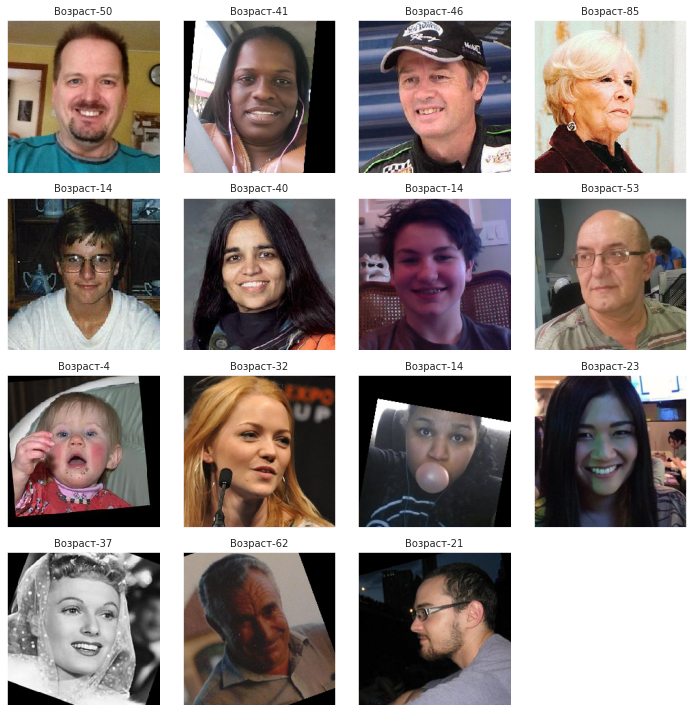

In [7]:
fig = plt.figure(figsize=(10,10))
for i in range(15):
    fig.add_subplot(4, 4, i+1)
    plt.imshow(features[i])
    plt.title(f'Возраст-{target[i]}', fontsize=10)
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

<b> Выводы по изображениям </b></font><br>

- Представлены фотографии разных возрастных групп
- На всех фотографиях большую часть композиции занимает лицо
- Большая часть фото - лица в анфас, некоторые - в профиль
- Имеются фотографии с измененным масштабом и горизонтом - значит до применения rescale фото были разномасштабные

В качестве метода аугментации выбран параметр для горизонтального отражения изображения, так объектов в датасете станет больше за свет создания якобы новой фото. 



## Обучение модели

Переносим сюда код обучения модели и её результат вывода на экран. Сам код запускался в отдельном GPU-тренажёре

```
def load_train(path):
    labels = pd.read_csv('{}/labels.csv'.format(path))
    train_datagen = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    validation_split=0.25) 
    train_datagen_flow = train_datagen.flow_from_dataframe(
    dataframe=labels,
    directory='{}/final_files/'.format(path),
    x_col='file_name',
    y_col='real_age',
    target_size=(224, 224),
    batch_size=32,
    class_mode='raw',
    subset='training',
    seed=12345)
    return train_datagen_flow


def load_test(path):
    labels = pd.read_csv('{}/labels.csv'.format(path))
    validation_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.25)
    val_datagen_flow = validation_datagen.flow_from_dataframe(
    dataframe=labels,
    directory='{}/final_files/'.format(path),
    x_col='file_name',
    y_col='real_age',
    target_size=(224, 224),
    batch_size=32,
    class_mode='raw',
    subset='validation',
    seed=12345)
    return val_datagen_flow


def create_model(input_shape):
    backbone = ResNet50(input_shape=input_shape,
                    weights='imagenet',
                    include_top=False)
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(units=1, activation='relu'))
    optimizer = Adam(lr=0.0001)
    model.compile(optimizer=optimizer, loss='mse',
                  metrics=['mae'])
    return model    
    
    
def train_model(model, train_data, test_data, batch_size=None, epochs=10,
               steps_per_epoch=None, validation_steps=None):
    model.fit(train_data, validation_data=test_data,    
    batch_size=batch_size, epochs=epochs,    
    steps_per_epoch=steps_per_epoch, validation_steps=validation_steps, verbose=2)

    return model

```

```
Train for 178 steps, validate for 60 steps
Epoch 1/10
178/178 - 51s - loss: 231.0854 - mae: 10.8903 - val_loss: 765.6734 - val_mae: 22.7515
Epoch 2/10
178/178 - 41s - loss: 76.4420 - mae: 6.5627 - val_loss: 744.5234 - val_mae: 22.2511
Epoch 3/10
178/178 - 41s - loss: 51.5699 - mae: 5.4572 - val_loss: 396.4150 - val_mae: 14.9418
Epoch 4/10
178/178 - 41s - loss: 35.3553 - mae: 4.5612 - val_loss: 105.6459 - val_mae: 7.8966
Epoch 5/10
178/178 - 41s - loss: 25.9577 - mae: 3.9127 - val_loss: 135.2487 - val_mae: 8.8735
Epoch 6/10
178/178 - 42s - loss: 22.0650 - mae: 3.5944 - val_loss: 71.9526 - val_mae: 6.4874
Epoch 7/10
178/178 - 41s - loss: 18.7671 - mae: 3.2778 - val_loss: 81.1696 - val_mae: 6.7940
Epoch 8/10
178/178 - 41s - loss: 16.2529 - mae: 3.0468 - val_loss: 83.3753 - val_mae: 6.7258
Epoch 9/10
178/178 - 41s - loss: 12.2411 - mae: 2.6669 - val_loss: 73.0106 - val_mae: 6.2857
Epoch 10/10
178/178 - 41s - loss: 10.7075 - mae: 2.4856 - val_loss: 66.2411 - val_mae: 6.1837
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
60/60 - 10s - loss: 66.2411 - mae: 6.1837
Test MAE: 6.1837



```

## Анализ обученной модели

Получилось построить модель, которая по фотографии сможет определять возраст посетителя. 

<b> Для этого выполнено </b></font><br>
Проведен препроцессинг данных. В этап аугментации вошел поворот изображения, также все фото приведены к одному масштабу.

Как устроена наша модель:
- Задан последовательный класс Sequential()
- Был использован в качестве оптимизации алгоритм ADAM, использована частота обучения (learning_rate) = 0.0001, что позволило более тчательно подбирать параметры нейронов при обучении.
- GlobalAveragePooling2D - слой для усреднения значения группы пикселей
- использовали архитектуру сверхточных сетей ResNet50 с весами ImageNet в качестве предобучения

Было указано 10 эпох для прогона датасета для оптимизации обучения и подстройки под имеющийся разброс в данных



Средняя абсолютная ошибка (MAE) на тестовой выборке: <b> 6.1837 </b></font><br>
